In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import torchvision.utils as utils
import torch.optim as optim

import matplotlib.pyplot as plt

In [138]:
'''
8 Class classification problem 

Initially work on trying to classifiy based on google search scraped pictures of these lightbulbs.
The problem with this is that they nearly always have a white backgroud and are not realistic of a phone camera version
of a picture of the light bulb
'current search: B15 light bulbs'

Classes
E27 light bulbs
E14 light bulbs
B22 light bulbs
B15 light bulbs
GU10 light bulbs
G4
G9
MR16


Need to also buy some examples of the light bulbs as a way of building up my own dataset that might be more realistic.

'''

"\n8 Class classification problem \n\nInitially work on trying to classifiy based on google search scraped pictures of these lightbulbs.\nThe problem with this is that they nearly always have a white backgroud and are not realistic of a phone camera version\nof a picture of the light bulb\n'current search: B15 light bulbs'\n\nClasses\nE27 light bulbs\nE14 light bulbs\nB22 light bulbs\nB15 light bulbs\nGU10 light bulbs\nG4\nG9\nMR16\n\n\nNeed to also buy some examples of the light bulbs as a way of building up my own dataset that might be more realistic.\n\n"

# Datasets

In [10]:
# Create a pytorch dataset, and then dataloader to allow for mini-batch processing. 
data_transform = transforms.Compose([
        transforms.RandomSizedCrop(128),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
        ])
    
light_bulbs = datasets.ImageFolder(root=r'C:\Users\awalker8\Documents\COVID_Furlow\bulb_class\bulb_data',
                                           transform=data_transform)
    
dataloader = torch.utils.data.DataLoader(light_bulbs,
                                             batch_size=64, shuffle=True,
                                             num_workers=2)

In [3]:
dataloader

torch.Size([1, 3, 128, 128])
(1, 128, 128, 3)
(128, 128, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


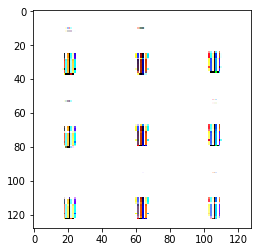

tensor([0])


In [86]:
for x, y in dataloader:
    print(x.shape)
    x.shape[0]
    out = np.reshape(x.numpy()[0,:,:,:],newshape =[x.shape[0],x.shape[2],x.shape[3],x.shape[1]])
    print(out.shape)
    print(out[0,:,:,:].shape)
    plt.imshow(out[0,:,:,:])
    plt.show()
    
    #plt.imshow(np.reshape(x.numpy()[0,:,:,:],newshape =[1,64,64,3]))
    #plt.show()
    print(y) # image label
    break

# CNN

In [4]:
# Defining the weights_init function that takes as input a neural network m and that will initialize all its weights.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [5]:
# Define the classifier

class bulb_model(nn.Module):
    
    def __init__(self):
        super(bulb_model, self).__init__()
    
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            # add a max pooling layer
            nn.MaxPool2d(kernel_size =3 , stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True), 
            nn.Conv2d(128, 256, 4, 2, 1, bias = False), 
            nn.MaxPool2d(kernel_size =2 , stride=1, padding=0),
            nn.BatchNorm2d(256), 
            nn.LeakyReLU(0.2, inplace = True), 
            nn.Conv2d(256, 512, 4, 2, 1, bias = False),
            nn.BatchNorm2d(512), 
            nn.LeakyReLU(0.2, inplace = True), 
            nn.Conv2d(512, 10, 4, 1, 0, bias = False), 
            nn.Flatten(),
            nn.Linear(160, 512),
            nn.Dropout(p=0.2),
            nn.Linear(512, 128),
            nn.Dropout(p=0.2),
            nn.Linear(128, 10),
            nn.Softmax()
        )
        
    def forward(self, input):
        output = self.main(input)
        return output

In [6]:
classifier_1 = bulb_model()
classifier_1.apply(weights_init)

bulb_model(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Leaky

In [7]:
# print(classifier_1) will output the setup of the model. 

# Train classifier

In [8]:
# create an optimiser for the classifier
optimiser_bulb = optim.Adam(classifier_1.parameters(), lr=0.002, betas = (0.9,0.999))
# Create a criterion. Lets use cross entropy loss. 
criterion = nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')

In [20]:
for epoch in range(1):

    for data, labels in dataloader:
        i = 1
        # push the image through the network
        prediction = classifier_1(data)
        print(prediction)
        print(prediction.shape)
        print(labels)
        if i == 1:
            break

tensor([[0.0818, 0.0969, 0.0919, 0.1244, 0.1035, 0.0768, 0.1293, 0.1060, 0.1008,
         0.0887],
        [0.0885, 0.0882, 0.0915, 0.1034, 0.0768, 0.1255, 0.1183, 0.0875, 0.1146,
         0.1055],
        [0.0804, 0.0620, 0.1172, 0.1340, 0.0968, 0.0877, 0.1308, 0.1131, 0.1021,
         0.0761],
        [0.1193, 0.0943, 0.0670, 0.1103, 0.0972, 0.0630, 0.1377, 0.1222, 0.1033,
         0.0859],
        [0.0543, 0.0879, 0.1368, 0.0570, 0.0761, 0.0739, 0.1835, 0.0964, 0.1501,
         0.0840],
        [0.0673, 0.1524, 0.0767, 0.0649, 0.0859, 0.1129, 0.0924, 0.1307, 0.1238,
         0.0932],
        [0.0651, 0.1025, 0.0969, 0.0850, 0.0609, 0.1006, 0.1218, 0.1336, 0.1394,
         0.0941],
        [0.0766, 0.0644, 0.0529, 0.0803, 0.0557, 0.0567, 0.0813, 0.0838, 0.1368,
         0.3115],
        [0.0463, 0.1796, 0.0837, 0.0626, 0.0431, 0.0644, 0.1030, 0.0936, 0.1742,
         0.1494],
        [0.1219, 0.1101, 0.1143, 0.1133, 0.0756, 0.0948, 0.0902, 0.1070, 0.0844,
         0.0883],
        [0

In [11]:
for epoch in range(1):
    i = 1
    for data, labels in dataloader:
     
        # push the image through the network
        prediction = classifier_1(data)
        
        error = criterion(prediction, labels)
        print('[%d/%d][%d/%d] Loss: %.4f' % (epoch, 25, i, len(dataloader),error))
  
        # zero grad
        classifier_1.zero_grad()
        error.backward()
        optimiser_bulb.step()
        
        #if i == 10:
        #   break
            
        i = i + 1

[0/25][1/71] Loss: 2.3081
[0/25][2/71] Loss: 2.3338


OSError: Caught OSError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "C:\Users\awalker8\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\utils\data\_utils\worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "C:\Users\awalker8\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\utils\data\_utils\fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Users\awalker8\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\utils\data\_utils\fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Users\awalker8\AppData\Local\Continuum\anaconda3\lib\site-packages\torchvision\datasets\folder.py", line 138, in __getitem__
    sample = self.loader(path)
  File "C:\Users\awalker8\AppData\Local\Continuum\anaconda3\lib\site-packages\torchvision\datasets\folder.py", line 174, in default_loader
    return pil_loader(path)
  File "C:\Users\awalker8\AppData\Local\Continuum\anaconda3\lib\site-packages\torchvision\datasets\folder.py", line 156, in pil_loader
    img = Image.open(f)
  File "C:\Users\awalker8\AppData\Local\Continuum\anaconda3\lib\site-packages\PIL\Image.py", line 2687, in open
    % (filename if filename else fp))
OSError: cannot identify image file <_io.BufferedReader name='C:\\Users\\awalker8\\Documents\\COVID_Furlow\\bulb_class\\bulb_data\\E14\\ledare-led-bulb-e14-400-lumen-warm-dimming-chandelier-clear__0557806_PE661004_S5JPG.jpg'>


In [ ]:
def show_image(image):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
plt.figure()
show_image(io.imread(os.path.join('C:\\Users\\awalker8\\Documents\\COVID_Furlow\\bulb_class\\bulb_data\\E14\\', 'ledare-led-bulb-e14-400-lumen-warm-dimming-chandelier-clear__0557806_PE661004_S5JPG.jpg')))
plt.show()

# Would be good to be able to show images from the loader whenever we fancy. Why can't i get this to work :()

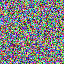

In [6]:
# View images from the dataloader. 
from torchvision.transforms import ToPILImage
from IPython.display import Image
to_img = ToPILImage()

# display tensor
a = torch.Tensor(3, 64, 64).normal_()
to_img(a)

In [7]:
# Helper function to show a batch
def show_bulb_batch(sample_batched):
    
    """Show image for a batch of samples."""
    images_batch = sample_batched[0][1]
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    plt.title('Batch from dataloader')


In [8]:
# for i_batch, sample_batched in enumerate(dataloader):
#     print(i_batch)
#     print(sample_batched[0][1].shape)
#     #ToPILImage(sample_batched[0][1])
#     #to_img(sample_batched[0][1])
    
#     if i_batch ==3:
#         break

In [9]:
import matplotlib.pyplot as plt

In [ ]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched[0].size())

    # observe 4th batch and stop.
    if i_batch == 1:
        plt.figure()
        show_bulb_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break